In [1]:
from sa import *
import os, json
import numpy as np

WEIGHT_FILE = "./qm.json"
TEST_INPUT = "./img0.npy"
RANDOM_MEM_GEN = False
DO_PRINT = False
GENERATE_ISA = True
with open(os.path.join(WEIGHT_FILE)) as fp:
    QM_DATA = json.loads(fp.read())
INPUT_DATA = np.array(np.load(os.path.join(TEST_INPUT))[0])

ADDR_MIN = 0x0000_0000
ADDR_MAX = 0x0002_0000
OFF_MEM_WB_BASE_ADDR = 0x0000_0000
OFF_MEM_UB_BASE_ADDR = 0x0001_AA80
UB_RESLUT_BASE_ADDR  = 32

FC1_SIZE = 0x0001_8800
FC2_SIZE = 0x0000_2000
FC3_SIZE = 0x0000_0280
UB_SIZE  = 0x0000_0310

FC1_OUTPUT_GOLDEN = np.load("./FC1_GOLDEN_VECTOR.npy")
FC2_OUTPUT_GOLDEN = np.load("./FC2_GOLDEN_VECTOR.npy")
FC3_OUTPUT_GOLDEN = np.load("./FC3_GOLDEN_VECTOR.npy")

Q = 5   # Q-Num format (Q-2.5)

In [2]:
# Functions for Compiler

# DATA/DATA : {'data', 'from', 'to', 'row', 'col'}
# ADDR : LSB=4(2**4=16B=1WORD)

def LOAD_DATA(SA:SYSTOLIC_ARRAY, OFF_MEM:BRAM, DATA: dict, ADDR: int):
    addr = ADDR # Start address
    for i in range(0, DATA['col'], 16):
        OFF_MEM.write(addr=addr, val=encode(np.flip(DATA['data'][i:i+16]), 16, 8))
        addr = addr + 1
    return addr # Return end address


def LOAD_WEIGHT(SA:SYSTOLIC_ARRAY, OFF_MEM:BRAM, WEIGHT: dict, ADDR: int) -> int:
    addr = ADDR # Start address
    for i in range(0, WEIGHT['col'], 16):
        for j in range(0, WEIGHT['row'], 16):
            tmp = WEIGHT['data'][j:j+16]
            tmp = tmp.transpose()[i:i+16]
            for k in range(16):
                OFF_MEM.write(addr=addr, val=encode(tmp[k].tolist(), 16, 8))
                addr = addr + 1
    return addr # Return end address


def PREPARE_FIFO(SA: SYSTOLIC_ARRAY, OFF_MEM: BRAM, WEIGHT_ADDR_FROM: int, WEIGHT_ADDR_TO:int,
                DATA_ADDR_FROM: int, DATA_ADDR_TO: int) -> list:
    # Write weight to WB
    for i in range(WEIGHT_ADDR_TO - WEIGHT_ADDR_FROM):
        SA.AXI_TO_WB_INST(OFF_MEM, i, WEIGHT_ADDR_FROM + i)

    # Write data to UB
    for i in range(DATA_ADDR_TO - DATA_ADDR_FROM):
        SA.AXI_TO_UB_INST(OFF_MEM, i, DATA_ADDR_FROM + i)

    # Fill WEIGHT FIFO
    WEIGHT_ADDR = WEIGHT_ADDR_FROM
    for i in range(4):
        SA.LOAD_WEIGHT(WEIGHT_ADDR)
        WEIGHT_ADDR = WEIGHT_ADDR + 1

    # Fill DATA FIFO
    DATA_ADDR = DATA_ADDR_FROM
    for i in range(4):
        SA.UB_TO_DATA_FIFO_INST(DATA_ADDR)
        DATA_ADDR = DATA_ADDR + 1

    return WEIGHT_ADDR, DATA_ADDR


def MATMUL_CALC(SA:SYSTOLIC_ARRAY, DATA: dict, WEIGHT: dict, DATA_ADDR: int, WEIGHT_ADDR: int, UB_ADDR: int):
    ACC_ADDR_FROM = 0
    ACC_ADDR_TO = 0
    for i in range(0, WEIGHT['col'], 16):
        ACC_ADDR = ACC_ADDR_FROM
        for j in range(0, WEIGHT['row'], 16):
            # Load weight
            for k in range(16):
                SA.LOAD_WEIGHT(WEIGHT_ADDR)
                WEIGHT_ADDR = WEIGHT_ADDR + 1
            # Calc
            if (i == 0):
                SA.MAT_MUL(ACC_ADDR)
            else:
                SA.MAT_MUL_ACC(ACC_ADDR)
            ACC_ADDR = ACC_ADDR + 1
        ACC_ADDR_TO = ACC_ADDR - 1
        SA.UB_TO_DATA_FIFO_INST(DATA_ADDR)
        DATA_ADDR = DATA_ADDR + 1
    
    UB_ADDR_FROM = UB_ADDR
    for i in range(ACC_ADDR_TO-ACC_ADDR_FROM+1):
        SA.WRITE_RESULT(UB_ADDR, ACC_ADDR_FROM + i)
        UB_ADDR = UB_ADDR + 1
    UB_ADDR_TO = UB_ADDR - 1
    
    return UB_ADDR_FROM, UB_ADDR_TO


def WRITE_RESULT_UB(SA:SYSTOLIC_ARRAY, OUTPUT_SIZE: int, ADDRA: int, ADDRB: int):
    for i in range(0, OUTPUT_SIZE, 16):
        SA.WRITE_RESULT(ADDRA + i, ADDRB + i)


def WRITE_RESULT_AXI(SA:SYSTOLIC_ARRAY, OFF_MEM:BRAM, ADDRA: int, ADDRB: int):
    pass


In [3]:
# Instantiation
SA = SYSTOLIC_ARRAY(gen_isa=GENERATE_ISA, USE_Q_NUMBER=True, Q=4)
OFF_MEM = BRAM(depth=8192, data_num=16, nbits=8)

In [4]:
SA.START_GEN_ISA()

# Weight data
addr = 0

# FC1
WEIGHT_DATA = np.array(QM_DATA['weight']['FC1'])
print(f"FC1 FROM:{addr}")
for i in range(0, 768, 16):
    for j in range(0, 128, 16):
        tmp = WEIGHT_DATA[j:j+16]
        tmp = tmp.transpose()[i:i+16]
        for k in range(16):
            OFF_MEM.write(addr=addr, val=encode(tmp[k].tolist(), 16, 8))
            addr = addr + 1
print(f"FC1 TO:{addr}")
            
# FC2
WEIGHT_DATA = np.array(QM_DATA['weight']['FC2'])
print(f"FC2 FROM:{addr}")
for i in range(0, 128, 16):
    for j in range(0, 64, 16):
        tmp = WEIGHT_DATA[j:j+16]
        tmp = tmp.transpose()[i:i+16]
        for k in range(16):
            OFF_MEM.write(addr=addr, val=encode(tmp[k].tolist(), 16, 8))
            addr = addr + 1
print(f"FC2 TO:{addr}")
            
# FC3
WEIGHT_DATA = np.pad(np.array(QM_DATA['weight']['FC3']), ((0,6),(0,0)))
print(f"FC3 FROM:{addr}")
for i in range(0, 64, 16):
    for j in range(0, 16, 16):
        tmp = WEIGHT_DATA[j:j+16]
        tmp = tmp.transpose()[i:i+16]
        for k in range(16):
            OFF_MEM.write(addr=addr, val=encode(tmp[k].tolist(), 16, 8))
            addr = addr + 1
print(f"FC3 TO:{addr}")

# Input data
DATA_ADDR_BASE = addr
for i in range(0, 768, 16):
    OFF_MEM.write(addr=addr, val=encode(np.flip(INPUT_DATA[i:i+16]), 16, 8))
    addr = addr + 1
    

# Write weight to WB
for i in range(6144+512+64):
    SA.AXI_TO_WB_INST(OFF_MEM, i, i)

# Write data to UB
for i in range(48):
    SA.AXI_TO_UB_INST(OFF_MEM, i, DATA_ADDR_BASE + i)

# Init FIFOs
WEIGHT_ADDR = 0
DATA_ADDR   = 0
for i in range(4):
    SA.LOAD_WEIGHT(WEIGHT_ADDR)
    WEIGHT_ADDR = WEIGHT_ADDR + 1
for i in range(4):
    SA.UB_TO_DATA_FIFO_INST(DATA_ADDR)
    DATA_ADDR = DATA_ADDR + 1

# MATRIX MULT (FC1)
for i in range(0, 768, 16):
    ACC_ADDR = 0
    for j in range(0, 128, 16):
        # Load weight
        for k in range(16):
            SA.LOAD_WEIGHT(WEIGHT_ADDR)
            WEIGHT_ADDR = WEIGHT_ADDR + 1
        #SA.MMU.weight_print(dec=True)
        # Calc
        #print(f"AIN:{SA.DATA_FIFO.data[-1]}")
        if (i == 0):
            SA.MAT_MUL(ACC_ADDR)
        else:
            SA.MAT_MUL_ACC(ACC_ADDR)
        ACC_ADDR = ACC_ADDR + 1
    #print("")
    SA.UB_TO_DATA_FIFO_INST(DATA_ADDR)
    DATA_ADDR = DATA_ADDR + 1

# Write result (FC1)
FC1_RESULT_ADDR_FROM = 0
for i in range(8):
    SA.WRITE_RESULT(i, i)
FC1_RESULT_ADDR_TO = 8
print(f"FC1:{SA.UB.data[FC1_RESULT_ADDR_FROM:FC1_RESULT_ADDR_TO]}")

# Prepare Next Calculation (FC2)
#print(f"UB:{SA.UB.data[FC1_RESULT_ADDR_FROM:FC1_RESULT_ADDR_TO]}")
DATA_ADDR = FC1_RESULT_ADDR_FROM
for i in range(4):
    SA.UB_TO_DATA_FIFO_INST(DATA_ADDR)
    DATA_ADDR = DATA_ADDR + 1
print(f"FIFO:{SA.DATA_FIFO.data}")


# MATRIX MULT (FC2)
for i in range(0, 128, 16):
    ACC_ADDR = 0
    for j in range(0, 64, 16):
        # Load weight
        for k in range(16):
            SA.LOAD_WEIGHT(WEIGHT_ADDR)
            WEIGHT_ADDR = WEIGHT_ADDR + 1
        # Calc
        if (i == 0):
            SA.MAT_MUL(ACC_ADDR)
        else:
            SA.MAT_MUL_ACC(ACC_ADDR)
        ACC_ADDR = ACC_ADDR + 1
    SA.UB_TO_DATA_FIFO_INST(DATA_ADDR)
    DATA_ADDR = DATA_ADDR + 1

FC2_RESULT_ADDR_FROM = 0
for i in range(4):
    SA.WRITE_RESULT(i, i)
FC2_RESULT_ADDR_TO = 4
print(f"FC2:{SA.UB.data[FC2_RESULT_ADDR_FROM:FC2_RESULT_ADDR_TO]}")


# Prepare Next Calculation (FC3)
#print(f"UB:{SA.UB.data[FC2_RESULT_ADDR_FROM:FC2_RESULT_ADDR_TO]}")
DATA_ADDR = FC2_RESULT_ADDR_FROM
for i in range(FC2_RESULT_ADDR_FROM, FC2_RESULT_ADDR_TO):
    SA.UB_TO_DATA_FIFO_INST(DATA_ADDR)
    DATA_ADDR = DATA_ADDR + 1
#print(f"FIFO:{SA.DATA_FIFO.data}")

# MATRIX MULT (FC3)
for i in range(0, 64, 16):
    ACC_ADDR = 0
    for j in range(0, 16, 16):
        # Load weight
        for k in range(16):
            SA.LOAD_WEIGHT(WEIGHT_ADDR)
            WEIGHT_ADDR = WEIGHT_ADDR + 1
        # Calc
        if (i == 0):
            SA.MAT_MUL(ACC_ADDR)
        else:
            SA.MAT_MUL_ACC(ACC_ADDR)
        ACC_ADDR = ACC_ADDR + 1
    SA.UB_TO_DATA_FIFO_INST(DATA_ADDR)
    DATA_ADDR = DATA_ADDR + 1

FC3_RESULT_ADDR_FROM = 0
for i in range(1):
    SA.WRITE_RESULT(i, i)
FC3_RESULT_ADDR_TO = 1
print(f"FC3:{SA.UB.data[FC3_RESULT_ADDR_FROM:FC3_RESULT_ADDR_TO]}")

SA.UB_TO_AXI_INST(off_mem=OFF_MEM, addra=DATA_ADDR_BASE, addrb=0)

SA.END_GEN_ISA()

FC1 FROM:0
FC1 TO:6144
FC2 FROM:6144
FC2 TO:6656
FC3 FROM:6656
FC3 TO:6720
0000b00004ffffe00001ffff500000000070000affffb00006000090000900003fffffffffd00006
00009ffffeffffaffff600001fffff0000700002ffff300004ffffcffffafffff00001ffff600004
ffff300001fffffffffd00002ffffaffffc000040001200005ffff1ffffe00006fffedfffff00003
ffffe00002000060000300008ffff9000090000700002ffffd0000700001ffff9ffffc00007ffffd
ffff4ffff8fffffffffe00002ffffc0000200000ffffe00006000020000b00003fffff0000500002
ffffc00001ffff900002ffffa00008fffe6ffffb00003ffffbffffd0000200005000020000200005
00003000030000600007ffffd00007ffff60000100005ffffa00007ffffe00001ffffafffdd00005
00001000140000bfffffffffc0000100001ffffc00006fffff00000ffffaffffcffff9ffffd0000d
0000600007ffffe00003ffff300001000040000cffff80000a0000b0000afffffffffa0000000005
0000200000ffffbffffe00004fffffffffdffffbffff500004ffff9ffffdffffb00004ffff900002
ffff100002ffff80000000005ffff9fffff000040000b00005ffff0fffff00000fffebffffa00001
0000400005000070000900006000010000

ffffcffffd0000effff600002ffffeffff6ffff900004ffffdffff6fffedffffd00003ffffcffff9
00007fffd9ffffd00005fffe2fffff000070000500001fffeffffffffff8ffff9ffffa00006ffff9
00010ffffa000120001d00009ffff300015ffff9ffffb000030000d0000000002ffff90000c00007
fffdfffffdfffed00000ffffbfffd8ffffbffff500032fffc2ffff1fffffffff0ffff50000300003
ffff100003ffff9ffff1fffeb00000ffff7fffe70000affffc0000900012ffff7ffff7fffe90000f
00012000010000400008ffffeffff6ffffaffff6fffedfffff000140001100038000130000a00005
fffc900008ffffaffff400015ffffc0002900004ffffd0000effffe00003fffffffffb000040000e
ffff9ffff90000bffff500006fffdc0001e000170000dffffcffff9ffff800009ffff200001fffde
0000b0002d0001c0000800008ffff40000a0000effffeffffeffff0ffffaffffe000090000900001
ffff30000e0001000003ffff4ffffa0000000013ffffdffff2ffffeffff5ffff9ffff80000900004
fffea000060000d0001b00003ffffd00002ffff9000020000300000ffffa0000000000000050000c
ffffa00001000040000900003fffe5fffffffffc00008fffe90001f00003ffff3ffff9fffff00004
0000100004ffffd00001fffec000

In [5]:
RES = []
for addr in range(FC3_RESULT_ADDR_FROM, FC3_RESULT_ADDR_TO, 1):
    RES = RES + np.flip(np.array(decode(SA.UB.data[addr], 16, 8))).tolist()
RES = np.array(RES)
print(RES)


[  5  38  52  79 -20  65 -20 -24  60  41   0   0   0   0   0   0]


In [6]:
print(FC3_OUTPUT_GOLDEN[0])
#print(np.array(QM_DATA['weight']['FC3']))

[  7  40  55  79 -19  67 -18 -24  61  39]


(10,)
-111.89245254371


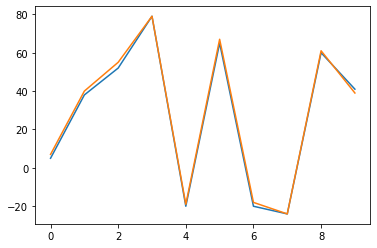

In [7]:
import matplotlib.pyplot as plt

RES = RES[0:10]
plt.plot(RES)
plt.plot(FC3_OUTPUT_GOLDEN[0])

similar_rate = 0
print(RES.shape)
for i in range(RES.shape[0]):
    similar_rate = similar_rate + abs((RES[i]-FC1_OUTPUT_GOLDEN[0][i])/FC1_OUTPUT_GOLDEN[0][i]) * 100
similar_rate = 100 - (similar_rate / RES.shape[0])
print(similar_rate)

In [8]:

with open("./TEST_OFF_MEM.mem", "w") as fp:
    for i in range(0, 8192):
        fp.write(OFF_MEM.data[i] + "\n")


6720
[  5  38  52  79 -20  65 -20 -24  60  41   0   0   0   0   0   0]


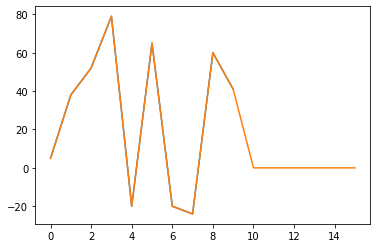

In [9]:
print(DATA_ADDR_BASE)
T = np.flip(decode(OFF_MEM.data[DATA_ADDR_BASE], 16, 8))
print(T)
plt.plot(T[0:10])
T2 = np.flip(decode("000000000000293ce8ec41ec4f342605", 16, 8))
plt.plot(T2)

[[ -16  -42  127  -16    6  -36   36   12  -19   -7   12   16    8   27
     9 -128  -33   -1  -45   27   10   -4  -39   -1  -30   12   -3  -17
    37   -6 -126   68   77  -93  -42   -3  -20    9   12  -17  -35    1
   -11   16  127   -1    3    0  -45    9   77    6   74  -95    1   32
    49  -13   29   -7  -20  -24   15 -128]]


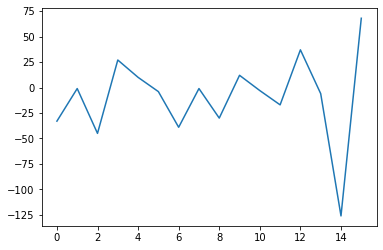

In [10]:
print(FC2_OUTPUT_GOLDEN)
plt.plot(FC2_OUTPUT_GOLDEN[0][16:32])

In [11]:
SA.MMU.K

8

In [12]:
encode([-16,-16,-16,-16], 4, 8)

'f0f0f0f0'

In [13]:
decode("80808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080", 784, 8)

[-128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,
 -128,

In [14]:
for i in range(0, 784, 16):
    print(encode(np.flip(INPUT_DATA[i:i+16]), 16, 8))

f0f0f0f0f0f0f0f0f0f0f0f0f0f0f0f0
f0f0f0f0f0f0f0f0f0f0f0f0f0f0f0f0
f0f0f0f0f0f0f0f0f0f0f0f0f0f0f0f0
f0f0f0f0f0f0f0f0f0f0f0f0f0f0f0f0
f0f0f0f0f0f0f0f0f0f0f0f0f0f0f0f0
f0f0f0f0f0f0f0f0f0f0f0f0f0f0f0f0
f0f0f0f0f0f0f0f0f0f0f0f0f0f0f0f0
0bf4f0f0f0f0f0f0f0f0f0f0f0f0f0f0
f0f0f0f0f0f0f0f0f0f0f0f0f0f60510
f0fb1010100f03f4f0f0f0f0f0f0f0f0
f0f0f0f0f0f0f0f0f0f0f0f0f0f0f0f0
f0f0f0f0f0fb10101010100bf4f0f0f0
0e01f0f0f0f0f0f0f0f0f0f0f0f0f0f0
f0f0f0f0f0f0f0f0f0fb1010050d1010
fdf30210100f01f0f0f0f0f0f0f0f0f0
f0f0f0f0f0f0f0f0f0f0f0f0f0fb1010
f0fb101007f0f1fa10100cf0f0f0f0f0
f0f0f0f0f0f0f0f0f0f0f0f0f0f0f0f0
f0f0f0f0f0f20c100efcf0f10206f4f0
f1f2f0f0f0f0f0f0f0f0f0f0f0f0f0f0
f0f0f0f0f0f0f0f0f0f0fa0e100ef7f0
101007f3f0f0f0f0f0f0f0f0f0f0f0f0
f0f0f0f0f0f0f0f0f0f0f0f0f0f0f00a
f0f3060e10101007f3f0f0f0f0f0f0f0
f0f0f0f0f0f0f0f0f0f0f0f0f0f0f0f0
f0f0f0f0f0fb10101010101007f3f0f0
10fbf0f0f0f0f0f0f0f0f0f0f0f0f0f0
f0f0f0f0f0f0f0f0f0ff100e090e1010
f0f8060e10fbf0f0f0f0f0f0f0f0f0f0
f0f0f0f0f0f0f0f0f0f0f0f0f00c1006
f0091008f1

In [16]:
OFF_MEM.data[6720]

'000000000000293ce8ec41ec4f342605'